# ECG analysis of T-wave

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import shutil
import posixpath
import gpflow
f64 = gpflow.utilities.to_default_float
from gpflow.kernels import *
import csv
import scipy.stats as stats
from scipy.signal import periodogram, butter, filtfilt
import os
import warnings
import importlib
import toolbox as t
import seaborn as sns
# import PlottingToolbox as pt
import tensorflow as tf
from tensorflow_probability import distributions as tfd
from SpectralMixture import SpectralMixture, initialize_from_emp_spec
import wfdb
import BNQD
from bnqdflow import models, base, effect_size_measures, util, analyses

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Load in data

In [19]:
sns.set(style='whitegrid')
record = wfdb.rdrecord('datasets/Real heartbeat/e0104')
annotation = wfdb.rdann('datasets/Real heartbeat/e0104', 'atr')
fs = record.fs
nyquist = fs/2
n = 1200 #816
step_down = 1 # down sampling factor
cutoff_high = 1.0    # Frequency is adjusted for in scipy.butter()
cutoff_low  = nyquist/step_down     # Frequency is adjusted for in scipy.butter()

# Initial samples (Normal T-wave)
normal_wave = record.p_signal[:int(n/2),1]
start_twave = int((13*60 + 35.3) * fs) # time slot taken from annotations
t0_wave     = record.p_signal[np.arange(start_twave,start_twave+int(n/2)-30),1]
n           = n - 30

# Combine data
y = np.concatenate((normal_wave, t0_wave))

# Standardize data
zscorey = lambda x: (x - np.mean(y)) / np.std(y)
zscorex = lambda x: (x - np.mean(X)) / np.std(X)
Y = zscorey(y)
Y_plot = Y
print(np.std(y))
print(np.mean(y))

0.2146440935043964
-1.5091068376068375


/home/david/Documenten/Courses/Thesis/Implementation/Thesis/Code


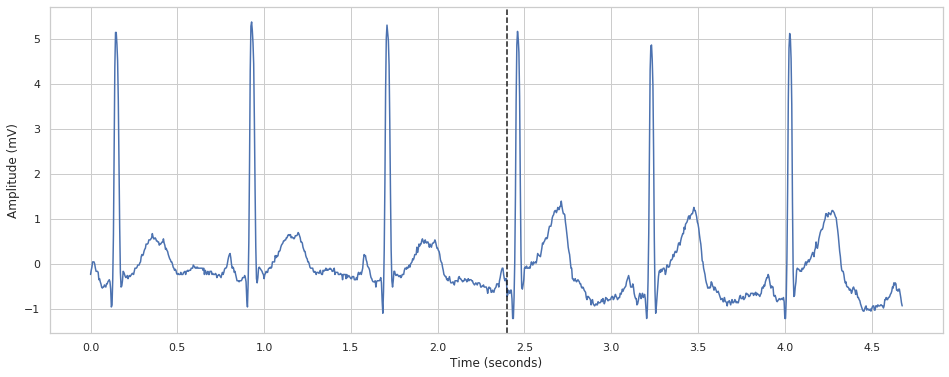

In [20]:
# Plot for in the paper
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig, ax = plt.subplots(1,1,figsize=(16,6))
plt.plot(np.arange(n),Y)
plt.axvline(600,color='k', linestyle='--')
plt.xticks(np.arange(0,1200, 125),np.arange(0,5,0.5))
#plt.yticks([-0.5,-1,-1.5])
plt.ylabel('Amplitude (mV)')
plt.xlabel('Time (seconds)')
import os
print(os.getcwd())
#plt.savefig('/home/david/Documenten/Courses/Thesis/Figures/ECG analysis/data.png')
plt.show()

/home/david/Documenten/Courses/Thesis/Implementation/Thesis/Code


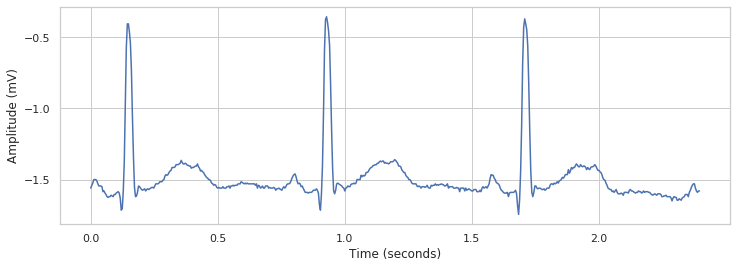

/home/david/Documenten/Courses/Thesis/Implementation/Thesis/Code


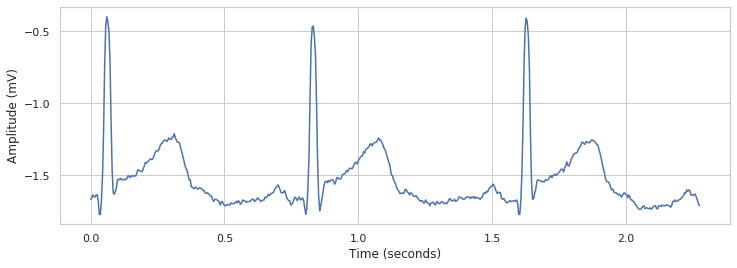

In [27]:
# Plot for in the paper
from matplotlib.ticker import LinearLocator, FormatStrFormatter
sns.set(style='whitegrid')
fig, ax = plt.subplots(1,1,figsize=(12,4))
plt.plot(np.arange(len(normal_wave)),normal_wave)
plt.xticks(np.arange(0,len(normal_wave), 125),np.arange(0,5,0.5))
plt.yticks([-0.5,-1,-1.5])
plt.ylabel('Amplitude (mV)')
plt.xlabel('Time (seconds)')
import os
print(os.getcwd())
plt.savefig('/home/david/Documenten/Courses/Thesis/Figures/ECG analysis/normalwave_data.pdf',dpi=400)
plt.show()


fig, ax = plt.subplots(1,1,figsize=(12,4))
plt.plot(np.arange(len(t0_wave)),t0_wave)
plt.xticks(np.arange(0,len(t0_wave), 125),np.arange(0,5,0.5))
plt.yticks([-0.5,-1,-1.5])
plt.ylabel('Amplitude (mV)')
plt.xlabel('Time (seconds)')
import os
print(os.getcwd())
plt.savefig('/home/david/Documenten/Courses/Thesis/Figures/ECG analysis/twave_data.pdf', dpi=400)
plt.show()

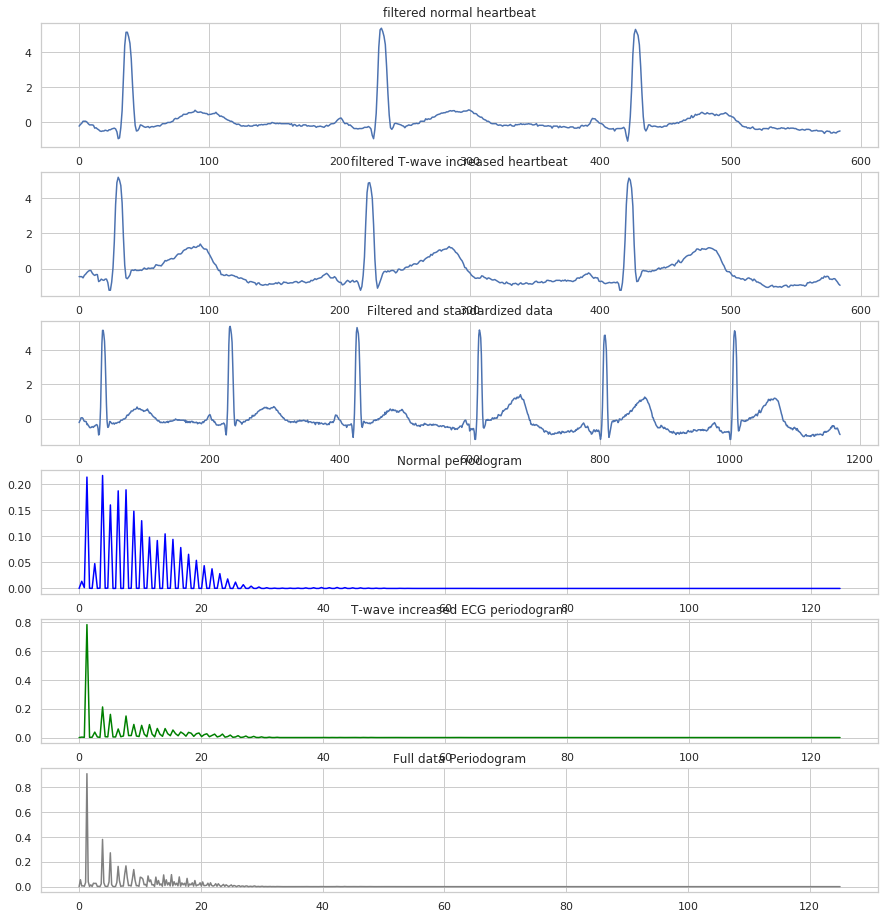

In [5]:


# plot unprocessed data
fig, ax = plt.subplots(6,1, figsize=(15,16))
ax[0].plot(np.arange(int(n/2)), Y[:(int(n/2))])
ax[0].set_title('filtered normal heartbeat')
ax[1].plot(np.arange(int(n/2)), Y[int(n/2):])
ax[1].set_title('filtered T-wave increased heartbeat')
ax[2].plot(np.arange(n), Y)
ax[2].set_title('Filtered and standardized data')

# Plot periodogram
freqs, Pxx = periodogram(x=Y[:int(n/2)], fs=fs)
ax[3].plot(freqs, Pxx, color='blue')
ax[3].set_title('Normal periodogram')
freqs, Pxx = periodogram(x=Y[int(n/2):], fs=fs)
ax[4].plot(freqs, Pxx, color='green')
#ax[4].set_ylim((0,0.2))
ax[4].set_title('T-wave increased ECG periodogram')
freqs, Pxx = periodogram(x=Y, fs=fs)
ax[5].plot(freqs, Pxx,color='grey')
ax[5].set_title('Full data Periodogram')
plt.show()




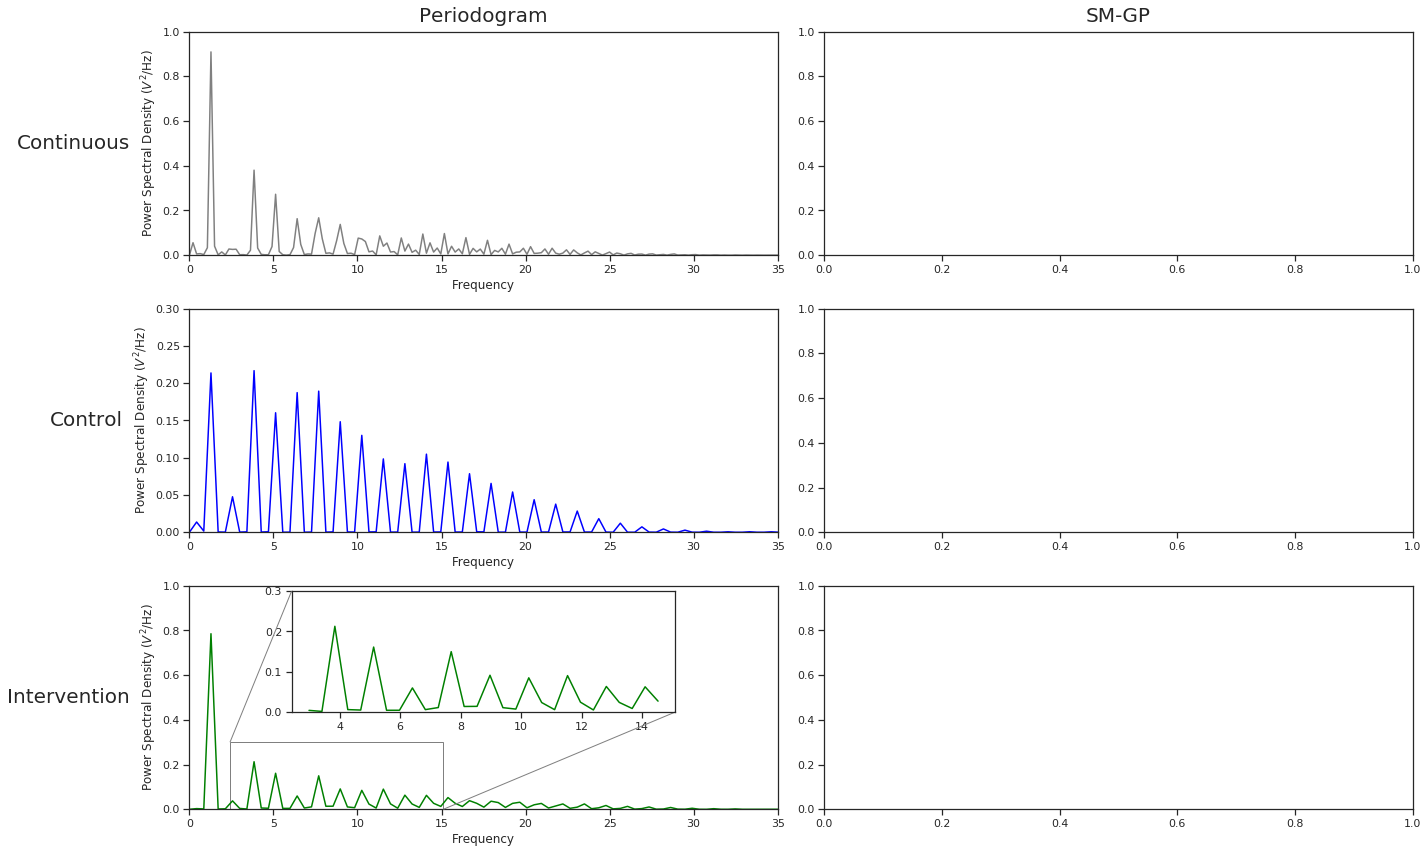

In [22]:
# Plots for paper
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Periodogram plots for paper
sns.set(style='ticks')
xlim_per = 35
fig, ax = plt.subplots(3,2,figsize=(20,12))

cols = ['{}'.format(row) for row in ['Periodogram','SM-GP']]
rows = ['{}'.format(row) for row in ['Continuous','Control', 'Intervention']]
pad = 5 # in points

for ax_x, col in zip(ax[0], cols):
    ax_x.annotate(col, xy=(0.5, 1.02), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=20, ha='center', va='baseline')

for ax_x, row in zip(ax[:,0], rows):
    ax_x.annotate(row, xy=(0, 0.5), xytext=(-ax_x.yaxis.labelpad - pad, 0),
                xycoords=ax_x.yaxis.label, textcoords='offset points',
                fontsize=20, ha='right', va='center')


freqs, Pxx = periodogram(x=Y_plot, fs=250)
ax[0,0].plot(freqs, Pxx,color='grey')
ax[0,0].set_xlim(0,xlim_per)
ax[0,0].set_ylim(0,1.)
ax[0,0].set_xlabel('Frequency')
ax[0,0].set_ylabel('Power Spectral Density ($V^2$/Hz)')
#ax[0,0].set_title('Continuous data periodogram',fontsize=18)
#plt.savefig('/home/david/Documenten/Courses/Thesis/Figures/ECG analysis/ecg_periodogram_estimates_grey.png')
#fig, ax = plt.subplots(1,1,figsize=(10,4))

freqs, Pxx = periodogram(x=Y_plot[:int(n/2)], fs=250)
ax[1,0].plot(freqs, Pxx, color='blue')
ax[1,0].set_xlim(0,xlim_per)
ax[1,0].set_ylim(0,.3)
ax[1,0].set_xlabel('Frequency')
ax[1,0].set_ylabel('Power Spectral Density ($V^2$/Hz)')
#ax[1,0].set_title('Regular annotated periodogram', fontsize=18)
ax[1,0].set_ylim()
#plt.savefig('/home/david/Documenten/Courses/Thesis/Figures/ECG analysis/ecg_periodogram_estimates_blue.png')

#fig, ax = plt.subplots(1,1,figsize=(10,4))
freqs, Pxx = periodogram(x=Y_plot[int(n/2):], fs=250)
ax[2,0].plot(freqs, Pxx, color='green')
#sns.set(style='whitegrid')
axins = zoomed_inset_axes(ax[2,0], 1.8, loc=9) # zoom = 6
axins.set_ylim(0,0.3)
axins.plot(freqs[7:35], Pxx[7:35], color='green')
mark_inset(ax[2,0], axins, loc1=2, loc2=4, fc="none", ec="0.5")
ax[2,0].set_xlim(0,xlim_per)
ax[2,0].set_ylim(0,1.)
ax[2,0].set_xlabel('Frequency')
ax[2,0].set_ylabel('Power Spectral Density ($V^2$/Hz)')
#ax[2].set_title('Elevated T-wave periodogram', fontsize=18)
#fig.suptitle('Periodogram', y =1.02, fontsize=20)
plt.tight_layout()

#plt.savefig('/home/david/Documenten/Courses/Thesis/Figures/ECG analysis/ecg_periodogram_estimates_green.png')

In [7]:
def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed


triangular_smoothing = False
bandpass = False
print(bandpass)
if triangular_smoothing:
    degree = 2
    Y = np.array(smoothTriangle(Y, degree))
    # # # Downsample to 250/degree Hz
    fs = fs/degree
    nyquist = fs/2
    print('fs: ', round(fs,2), 'nyquist: ', round(nyquist,2))
    Y = Y[np.arange(int(n))%degree==0]
    n = int(n/degree)
    Y = Y.reshape(n,1)


False


In [8]:
def bandpass_filter(Y, cutoff_low, cutoff_high):
    #apply low and high-pass filter
    b_high_filt, a_high_filt = butter(N=5, Wn=cutoff_high, btype='high', fs=fs)
    Y = filtfilt(b=b_high_filt, a=a_high_filt, x=Y)
    b_low_filt, a_low_filt = butter(N=5, Wn=cutoff_low, btype='low', fs=fs)
    Y = filtfilt(b=b_low_filt, a=a_low_filt, x=Y)
    return Y

if bandpass:
    # # Downsample to 62.5Hz
    Y = bandpass_filter(Y, cutoff_low, cutoff_high)
    fs = fs/step_down
    nyquist = fs/2
    print('fs: ', round(fs,2), 'nyquist: ', round(nyquist,2))
    # Decimate
    Y = Y[np.arange(int(n))%step_down==0]
    n = int(n/step_down)
    Y = Y.reshape(n,1)

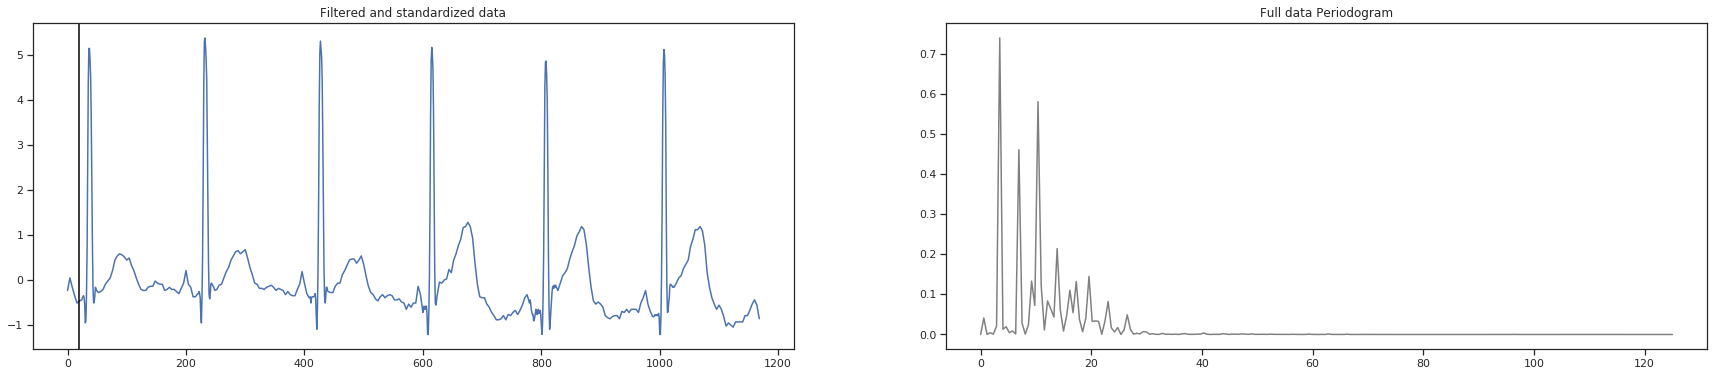

0.2146440935043964
-1.5091068376068375
335.0372655275699
576.9447004608295
250


In [9]:
# Downsample flat regions to prevent gettign stuck in local minima 
def get_indices(list_of_tuples, downsample_degree):
    d = len(list_of_tuples)
    unflattened_indices = []
    for i in range(d):
        start, end = list_of_tuples[i]
        indices = np.arange(start,end)
        indices = indices[indices%downsample_degree != 0]
        unflattened_indices.append(indices)
        
    return unflattened_indices

def concatinate_lists(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

# old indices
#tuple_indices = [(0,25),(50,170), (250, 375), (450,600), (620,770), (825,1000), (1025,1175)]
# new indices 
tuple_indices = [(0,25),(50,220), (250, 410), (440,600), (625,780), (825,990), (1025,1175)]

unflattened_indices = get_indices(tuple_indices, 4)
indices_to_remove = np.array(concatinate_lists(unflattened_indices))

indices = np.array([idx for idx in np.arange(n) if idx not in indices_to_remove])
X = indices
Y_filtered = Y[indices]
n = len(indices)
fs = fs 
nyquist = fs / 2
# plot unprocessed data
fig, ax = plt.subplots(1,2,figsize=(30,6))
ax[0].plot(indices, Y_filtered)
ax[0].axvline(20,color='black')
ax[0].set_title('Filtered and standardized data')

# Plot periodogram
freqs1, Pxx1 = periodogram(x=Y_filtered[:], fs=fs)
ax[1].plot(freqs1, Pxx1,color='grey')
ax[1].set_title('Full data Periodogram')
plt.show()
print(np.std(y))
print(np.mean(y))
print(np.std(X))
print(np.mean(X))
print(fs)

In [10]:
# plot unprocessed data
#tuple_indices = [(0,25),(50,220), (250, 410), (440,600), (625,780), (825,990), (1025,1175)]

# fig, ax = plt.subplots(1,2,figsize=(30,6))
# ax[0].plot(indices, Y_filtered)
# ax[0].axvline(1175,color='black')
# ax[0].set_title('Filtered and standardized data')

# # Plot periodogram
# freqs, Pxx = periodogram(x=Y_filtered[:], fs=fs)
# ax[1].plot(freqs, Pxx,color='grey')
# ax[1].set_title('Full data Periodogram')
# plt.show()

In [10]:
# Creating X labels
#X = np.arange(n)
Y = Y_filtered
b = 600
b = zscorex(b)
X = zscorex(X)

print(b)
print(X.shape)
xx = np.linspace(-n,n,n*5)
# Data used by the control model and intervention model
x1, x2      = X[X <= b,], X[X>b,]
y1, y2      = Y[X <= b,], Y[X>b,]
print(type(x1[0]))
xx1, xx2    = xx[xx <= 0.], xx[xx > 0.]
data        = [(x1, y1), (x2, y2)]
x = X
y = Y

# Kernels
periodic        = Periodic(SquaredExponential(), period=0.1)
damped_periodic = SquaredExponential(lengthscales=.2)*Periodic(SquaredExponential(),period=0.1)
colours_prior   = ['#1a1835', '#15464e', '#2b6f39', '#757b33', '#c17a70', '#d490c6', '#c3c1f2', '#cfebef']


# Plotting parameters
padding           = 0.5
ylim              = (-4.7,5.2)#(-2.5,2.3)

0.06881413475861033
(434,)
<class 'numpy.float64'>


In [12]:
# # # plot processed data
# fig, ax = plt.subplots(6,1, figsize=(15,16))
# ax[0].plot(x1, y1)
# ax[0].set_title('filtered normal heartbeat')
# ax[1].plot(x2, y2)
# ax[1].set_title('filtered T-wave increased heartbeat')
# ax[2].plot(X, Y)
# ax[2].set_title('Filtered and standardized data')

# # Plot periodogram
# freqs, Pxx = periodogram(x=y1, fs=fs)
# ax[3].plot(freqs, Pxx, color='blue')
# ax[3].set_title('Pre-intervention periodogram')
# freqs, Pxx = periodogram(x=y2, fs=fs)
# ax[4].plot(freqs, Pxx, color='green')
# ax[4].set_title('T-wave increased ECG periodogram')
# #ax[4].set_ylim((0,0.2))
# freqs, Pxx = periodogram(x=Y, fs=fs)
# ax[5].plot(freqs, Pxx,color='grey')
# ax[5].set_title('Continuous data Periodogram')
# plt.show()


In [13]:
# # Plots for paper
# # Periodogram plots for paper

# xlim_per = 50
# fig, ax = plt.subplots(3,1,figsize=(16,6))
# freqs, Pxx = periodogram(x=Y[:int(n/2)], fs=fs)
# print(len(freqs))
# ax[0].plot(freqs, Pxx, color='blue')
# ax[0].set_xlim(0,xlim_per)

# ax[0].set_title('Control group periodogram', fontsize=20)
# ax[0].set_ylim()

# freqs, Pxx = periodogram(x=Y[int(n/2):], fs=fs)
# ax[1].plot(freqs, Pxx, color='green')
# ax[1].set_xlim(0,xlim_per)

# ax[1].set_title('Elevated T-wave periodogram', fontsize=20)
# freqs, Pxx = periodogram(x=Y, fs=fs)
# ax[2].plot(freqs, Pxx,color='grey')
# ax[2].set_xlim(0,xlim_per)
# ax[2].set_title('Continuous data periodogram')
# plt.show()

## Spectral Mixture

In [16]:
sns.set(style='white')
print(x1.shape, x2.shape,y1.shape,y2.shape,X.shape,Y.shape)
# Run analysis Spectral Mixture
def set_sm_priors(sm):
    Q = len(sm.kernels)
    for i, kernel in enumerate(sm.kernels):
        kernel.mixture_weight.prior       = tfd.Gamma(f64(2.0), f64(0.9))
        kernel.frequency.prior            = tfd.Gamma(f64(2.0), f64(0.8))
        kernel.lengthscale.prior = tfd.Gamma(f64(5.0), f64(0.7))     
        
max_freq        = 230  # nyquist
print(nyquist, max_freq)
max_length      = 2.25
Q               = 25 #t.find_optimal_Q(x, y, min_Q=1, max_Q=40, max_length=max_length, max_freq=max_freq, plot_BIC_scores=True)
sm              = SpectralMixture(Q, max_length=max_length, max_freq=max_freq)                
#set_sm_priors(sm)    

a               = analyses.SimpleAnalysis([(x1, y1), (x2, y2)], sm, b, share_params=False)
a.train(verbose=False)
log_bayes_factor = a.log_bayes_factor(verbose=False)
print('Log bayes factor: ', log_bayes_factor.numpy())

print('\nControl')
for kernel in a.discontinuous_model.models[0].kernel.kernels:
      print('Index: ', kernel.index, '. Frequency: ',
            round(kernel.frequency.numpy(), 3), 'lengthscale: ', round(kernel.lengthscale.numpy(),3),
            'mixture weight: ', round(kernel.mixture_weight.numpy(),3))
print('intervention')
for kernel in a.discontinuous_model.models[1].kernel.kernels:
      print('Index: ', kernel.index, '. Frequency: ',
            round(kernel.frequency.numpy(), 3), 'lengthscale: ', round(kernel.lengthscale.numpy(),3),
           'mixture weight: ', round(kernel.mixture_weight.numpy(),3))
        

(215,) (219,) (215,) (219,) (434,) (434,)
125.0 230
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow te

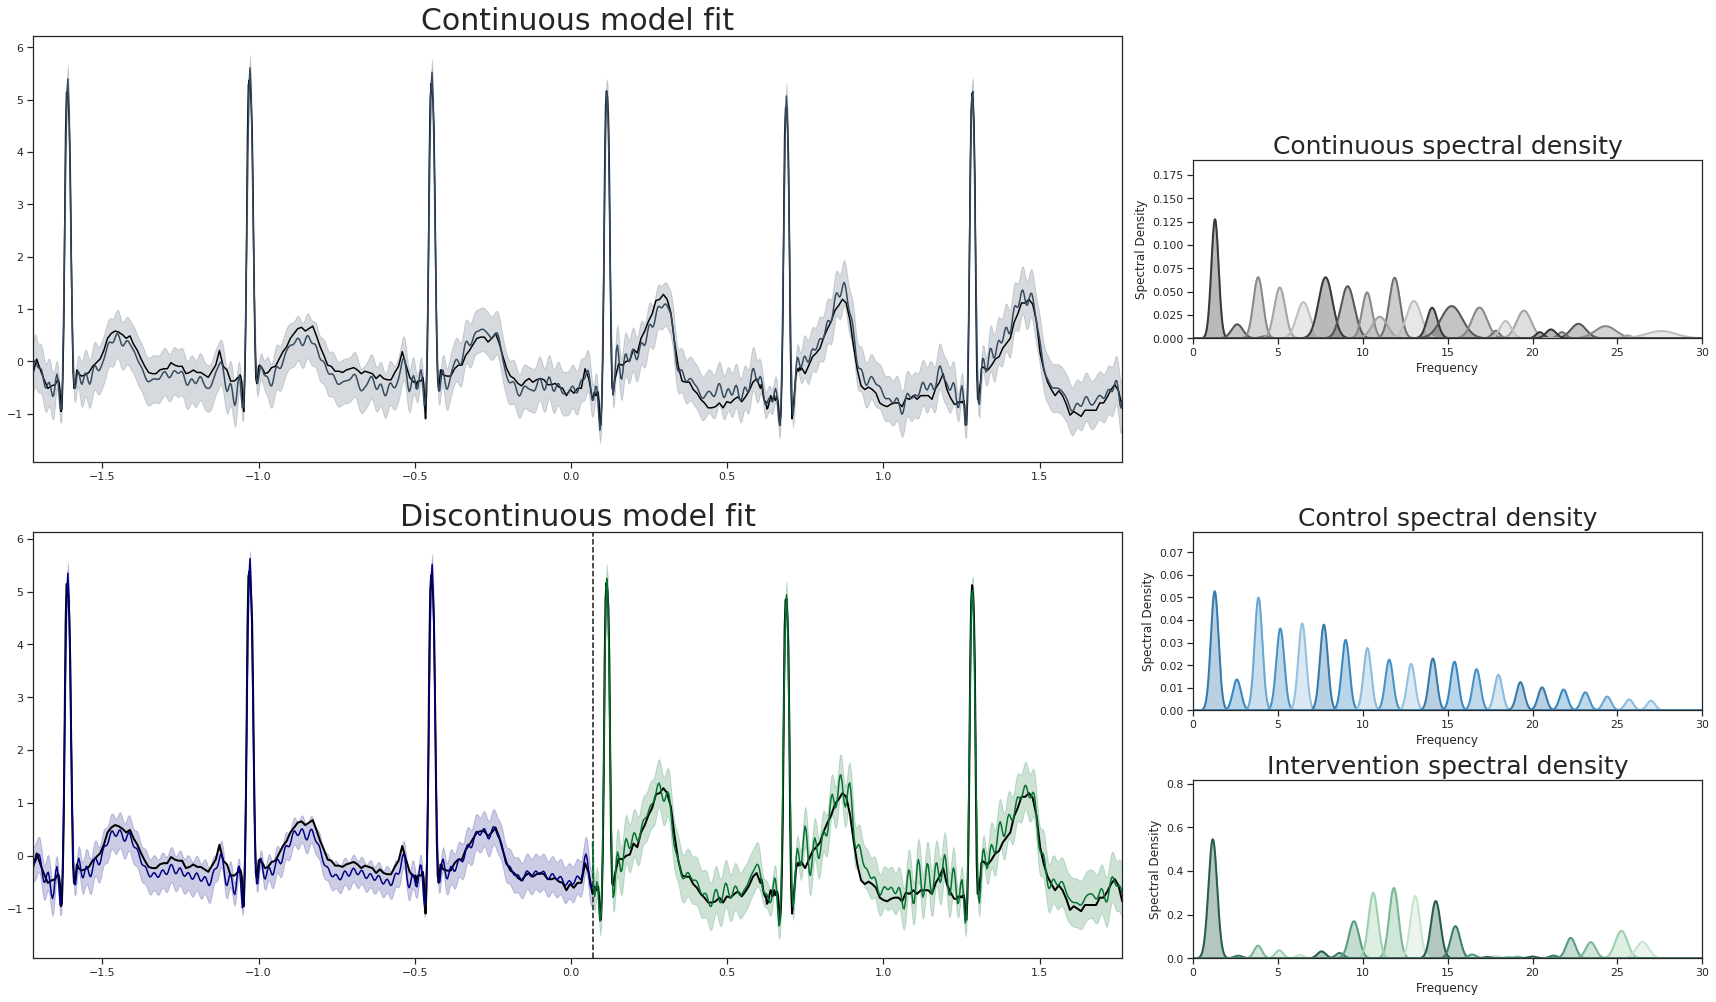

In [17]:
t.plot_posterior_model_spectrum(a, Q, padding=0, max_x = 200/(2*np.pi),lineplot=True, scalar = 0.7485)
#plt.savefig('ecg_test_result_MAP_oldindices_lineplot.pdf',dpi=400)
plt.show()

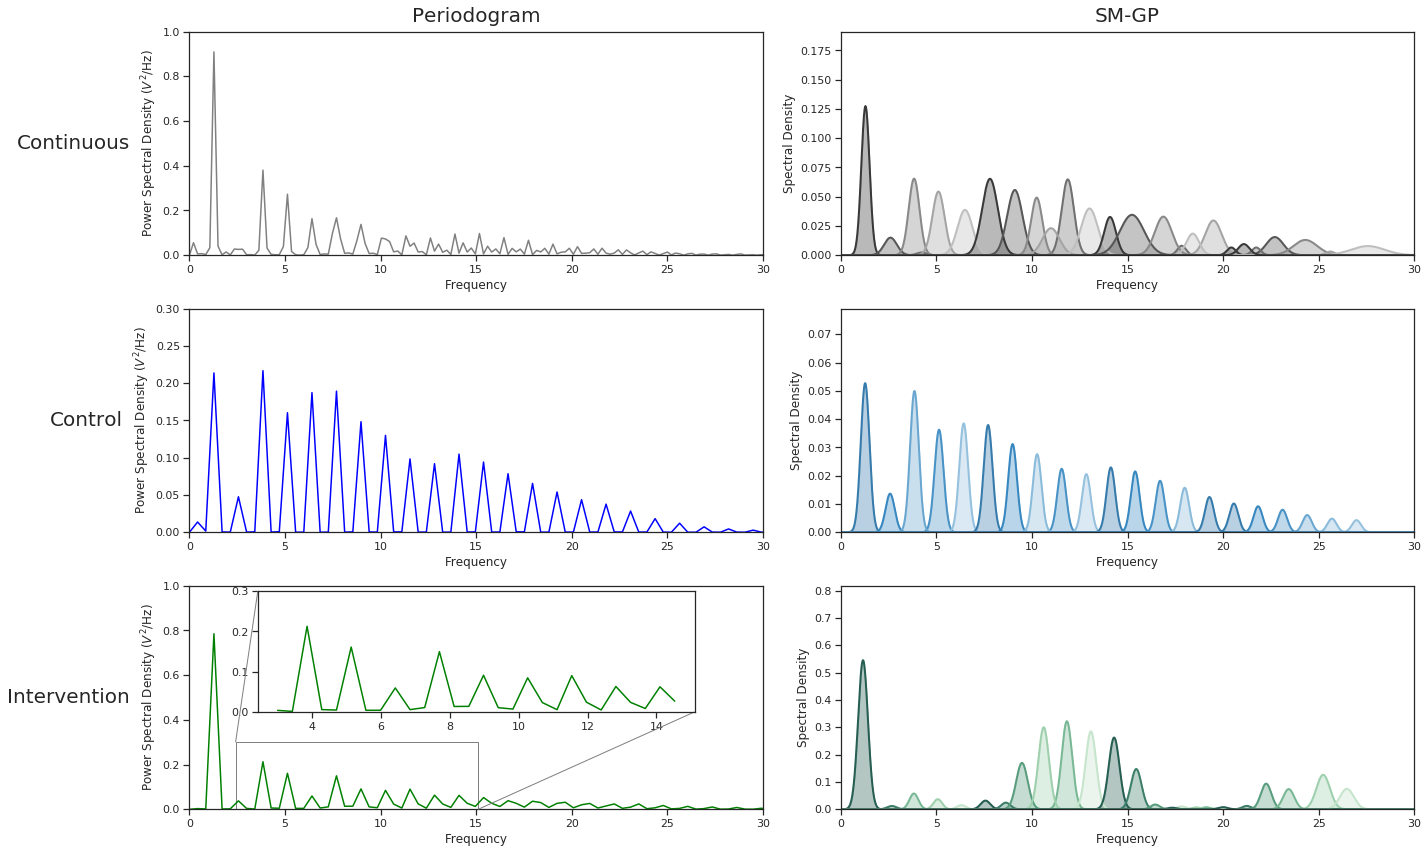

In [28]:
# Plots for paper
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Periodogram plots for paper
sns.set(style='ticks')
xlim_per = 35
fig, ax = plt.subplots(3,2,figsize=(20,12))

cols = ['{}'.format(row) for row in ['Periodogram','SM-GP']]
rows = ['{}'.format(row) for row in ['Continuous','Control', 'Intervention']]
pad = 5 # in points

for ax_x, col in zip(ax[0], cols):
    ax_x.annotate(col, xy=(0.5, 1.02), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=20, ha='center', va='baseline')

for ax_x, row in zip(ax[:,0], rows):
    ax_x.annotate(row, xy=(0, 0.5), xytext=(-ax_x.yaxis.labelpad - pad, 0),
                xycoords=ax_x.yaxis.label, textcoords='offset points',
                fontsize=20, ha='right', va='center')


freqs_plot, Pxx_plot = periodogram(x=Y_plot, fs=250)
xlim_per=30
ax[0,0].plot(freqs_plot, Pxx_plot,color='grey')
ax[0,0].set_xlim(0,xlim_per)
ax[0,0].set_ylim(0,1.)
ax[0,0].set_xlabel('Frequency')
ax[0,0].set_ylabel('Power Spectral Density ($V^2$/Hz)')
#ax[0,0].set_title('Continuous data periodogram',fontsize=18)
#plt.savefig('/home/david/Documenten/Courses/Thesis/Figures/ECG analysis/ecg_periodogram_estimates_grey.png')
#fig, ax = plt.subplots(1,1,figsize=(10,4))

freqs_plot, Pxx_plot = periodogram(x=Y_plot[:int(n/2)], fs=250)
ax[1,0].plot(freqs_plot, Pxx_plot, color='blue')
ax[1,0].set_xlim(0,xlim_per)
ax[1,0].set_ylim(0,.3)
ax[1,0].set_xlabel('Frequency')
ax[1,0].set_ylabel('Power Spectral Density ($V^2$/Hz)')
#ax[1,0].set_title('Regular annotated periodogram', fontsize=18)
ax[1,0].set_ylim()
#plt.savefig('/home/david/Documenten/Courses/Thesis/Figures/ECG analysis/ecg_periodogram_estimates_blue.png')

#fig, ax = plt.subplots(1,1,figsize=(10,4))
freqs_plot, Pxx_plot = periodogram(x=Y_plot[int(n/2):], fs=250)
ax[2,0].plot(freqs_plot, Pxx_plot, color='green')
#sns.set(style='whitegrid')
axins = zoomed_inset_axes(ax[2,0], 1.8, loc=9) # zoom = 6
axins.set_ylim(0,0.3)
axins.plot(freqs_plot[7:35], Pxx_plot[7:35], color='green')
mark_inset(ax[2,0], axins, loc1=2, loc2=4, fc="none", ec="0.5")
ax[2,0].set_xlim(0,xlim_per)
ax[2,0].set_ylim(0,1.)
ax[2,0].set_xlabel('Frequency')
ax[2,0].set_ylabel('Power Spectral Density ($V^2$/Hz)')
#ax[2].set_title('Elevated T-wave periodogram', fontsize=18)
#fig.suptitle('Periodogram', y =1.02, fontsize=20)
#
t.plot_model_spectra_new(a, Q, 2, ax[:,1], 1, max_x=30, padding=0.0, true_freqs=None,ylim=None, scalar=0.7485)
plt.tight_layout()

plt.savefig('ecgspectra3.pdf', dpi=150)
plt.show()
#plt.savefig('/home/david/Documenten/Courses/Thesis/Figures/ECG analysis/ecg_periodogram_estimates_green.png')

In [16]:
# t.plot_synthetic_control_posterior_spectrum(a, Q, padding=0, max_x = max_freq/(2*np.pi))
# plt.show()


In [29]:
e = t.EffectSizeGMM(a)
print(e)
e_KL = t.EffectSizeGMM(a, mode='KullbackLeibler')
print(e_KL)

1.1707442054517427
0.05422604749527893


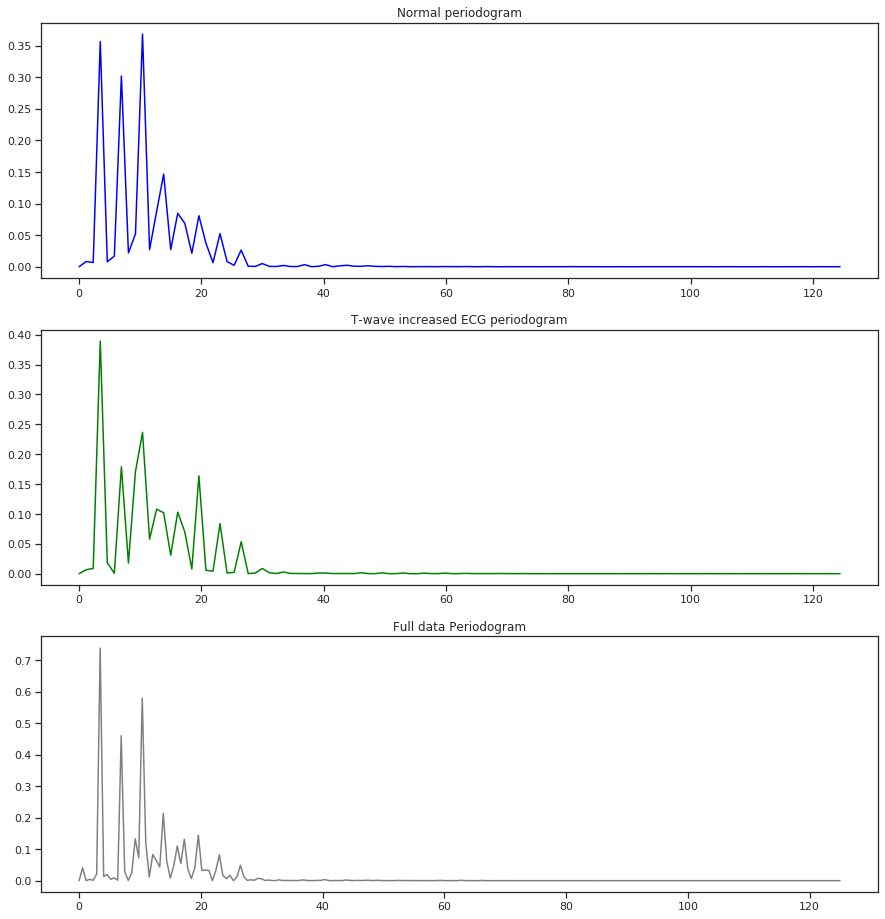

In [18]:
# plot unprocessed data
fig, ax = plt.subplots(3,1, figsize=(15,16))

# Plot periodogram
freqs, Pxx = periodogram(x=Y[:int(n/2)], fs=fs)
ax[0].plot(freqs, Pxx, color='blue')
ax[0].set_title('Normal periodogram')
freqs, Pxx = periodogram(x=Y[int(n/2):], fs=fs)
ax[1].plot(freqs, Pxx, color='green')
ax[1].set_title('T-wave increased ECG periodogram')
freqs, Pxx = periodogram(x=Y, fs=fs)
ax[2].plot(freqs, Pxx,color='grey')
ax[2].set_title('Full data Periodogram')
plt.show()

In [19]:
# Run HMC
import time
start = time.time()
gpflow.set_trainable(a.discontinuous_model.models[0].likelihood.variance, False)
combined_param_samples_control = t.HMC(m=a.discontinuous_model.models[0], n_burnin_steps=50, n_samples=4000, n_chains=4, step_size = 0.1)
end = time.time()
print('sampling duration: ', end - start)
kernels_control = t.kernel_density_estimation(combined_param_samples_control)
print(time.time()-end )

ValueError: `parameters` should only contain gpflow.Parameter objects with priors

In [4]:
import csv
import pickle

def save_csv(fname, kernels, mode='log_dens'):
    with open(fname, 'w', newline='') as f:
        writer = csv.writer(f)
        for (_, log_dens, samples)  in kernels:
            if mode=='log_dens':
                writer.writerow(log_dens)
            elif mode=='samples':
                writer.writerow(samples)
            else:
                print('Mode misspecified')
                
def save_pkl(fname, kernels):
    with open(fname, 'wb') as output:
        for (kde, _, _)  in kernels:
            pickle.dump(kde, output, pickle.HIGHEST_PROTOCOL)    
            
def load_csv(fname, mode='log_dens'):
    param_samples = []
    with open(fname, 'r', newline='') as f:
        reader = csv.reader(f)
        for samples in reader:
            if mode=='log_dens':
                param_samples.append(np.array(samples).astype(float))
            elif mode=='samples':
                param_samples.append(np.array(samples).astype(float))
            else:
                print('Mode misspecified')
    return param_samples
            
def load_pkl(fname, N):
    with open(fname, 'rb') as input:
        kde = []
        for i in range(1): 
            kde_param = pickle.load(input)
            print(kde_param)
            print(len(kde_param))
            kde.append(kde_param)
    return kde

In [ ]:
# # Save samples for control group
fname_samples_control = 'SimulationFiles/control_samples_output.csv'
save_csv(fname_samples_control, kernels_control, mode='samples')

# Save kernels for control group
fname_log_dens = 'SimulationFiles/control_log_dens_output.csv'
save_csv(fname_log_dens, kernels_control, mode='log_dens')

# Save kernels for control group
fname_kde_control = 'SimulationFiles/control_kde.pkl'
save_pkl(fname_kde_control, kernels_control)

In [10]:
# Load all files
# Save samples for control group
fname_samples_control = 'SimulationFiles/control_samples_output.csv'
samples_control = load_csv(fname_samples_control, mode='samples')
fname_samples_intervention = 'SimulationFiles/intervention_samples_output.csv'
samples_intervention = load_csv(fname_samples_intervention, mode='samples')
print(len(samples_intervention))
# # Save kernels for control group
fname_log_dens = 'SimulationFiles/control_log_dens_output.csv'
log_dens_control = load_csv(fname_log_dens, mode='log_dens')
fname_log_dens = 'SimulationFiles/intervention_log_dens_output.csv'
log_dens_intervention = load_csv(fname_log_dens, mode='log_dens')

# # Save kernels for control group
# fname_kde_control = 'control_kde.pkl'
# kde_control = load_pkl(fname_kde_control, 60)


60


In [ ]:
## Plot intervention samples against control samples
# fname_samples_control = 'control_samples_output.csv'
# samples_control = load_csv(fname_samples_control, mode='samples')
# fname_samples_intervention = 'intervention_samples_output.csv'
# samples_intervention = load_csv(fname_samples_control, mode='samples')

# control_freq_samples = np.array([])
# intervention_freq_samples = np.array([])
# for (samples_c,samples_i) in zip(samples_control,samples_intervention):
#     np.concatenate([control_freq_samples,samples_c])
#     intervention_freq_samples = np.concatenate([intervention_freq_samples,samples_i])
    
# plt.hist2d(control_freq_samples, intervention_freq_samples, bins=60)
# plt.title(f'Frequency of all components')
# plt.show()

In [ ]:
# # Frequency distributions
# for i, (kde,log_dens, samples) in enumerate(kernels):
#     if i%3 is 0:
#         xx = np.linspace(0, int(samples.max())+30, int(1000*samples.max())+1).reshape(-1, 1)
#         plt.figure()
#         plt.plot(xx, np.exp(log_dens), color='black', alpha=0.2,
#                 label=f'trainable parameter {i}')
#         plt.title(f'trainable parameter {i}')
#         plt.show()

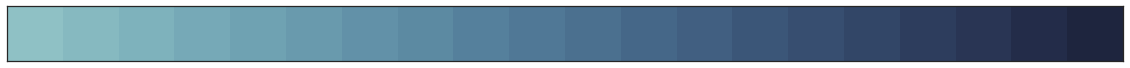

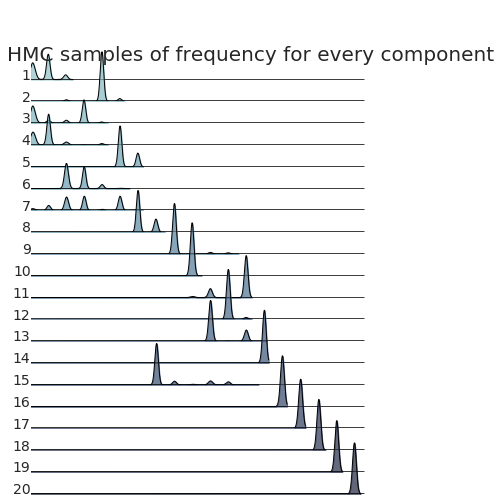

In [11]:
from sklearn.neighbors import KernelDensity

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

# number of parameters
N = 60 # len(kernels_control) 
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
freq_samples = []
# # When running hmc
# for i, (kde, log_dens, samples ) in enumerate(kernels_control):
#     if i%3 is 0:
#         #log_densities = kernel#[log_dens for i,(_,log_dens,samples) in enumerate(kernels) if i%3 is 0]
#         xx = np.linspace(0, int(samples.max()), int(1000*samples.max())+1)
#         freq_samples.append((log_dens,xx))

#When loading in data
for i in range(N):
    if i%3 is 0:
        samples = samples_control[i]
        max_val = max(samples)
        log_dens = log_dens_control[i]
        xx = np.linspace(0, int(max_val), int(1000*max_val)+1)
        freq_samples.append((log_dens,xx))

hls = sns.cubehelix_palette(len(freq_samples), rot=-.25, light=.7)
sns.palplot(hls)
blues = hls.as_hex()

gs = grid_spec.GridSpec(N,1)
fig = plt.figure(figsize=(6, 25))


ax_objs = []
for i, (log_dens,xx) in enumerate(freq_samples):
    
    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    xlim=200
    ax_objs[-1].plot(xx, np.exp(log_dens),color="black",lw=1)
    ax_objs[-1].plot(np.arange(0,xlim), [0 for i in range(xlim)], color='black')
    ax_objs[-1].fill_between(xx, np.exp(log_dens), alpha=0.7,color=blues[i])


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(0,xlim)
    ax_objs[-1].set_ylim(0,0.5)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == N-1:
        ax_objs[-1].set_xlabel("Frequency", fontsize=16)
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-0.2,0,i+1,fontsize=14,ha="right")


gs.update(hspace=-0.7)

fig.text(0.07,0.85,"HMC samples of frequency for every component",fontsize=20)

plt.tight_layout()
plt.savefig('Plots/initial_control_HMC_plot_nameunpsecifiedyet.png')
plt.show()

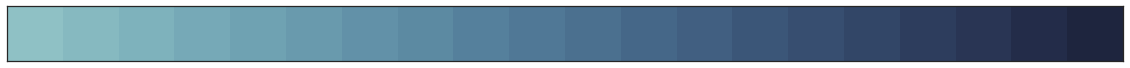

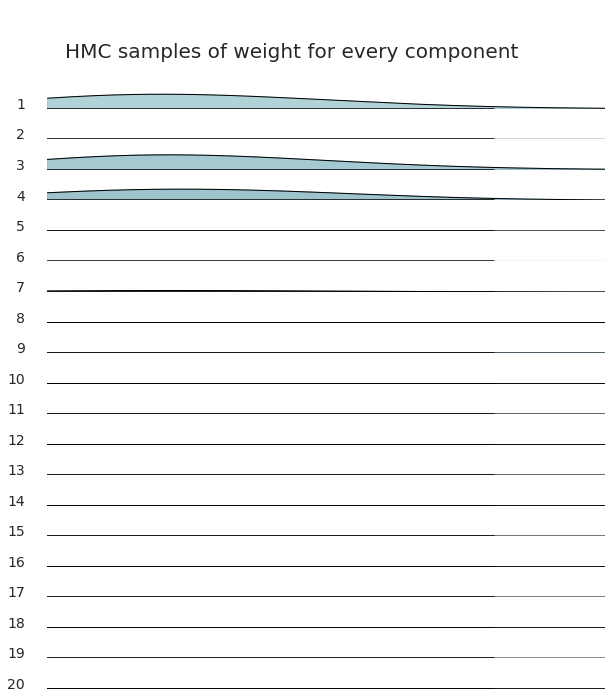

In [12]:
### Mixture weight

# number of parameters
N = 60 # len(kernels_control) 
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
freq_samples = []
# When running hmc
# for i, (kde, log_dens, samples ) in enumerate(kernels_control):
#     if i%3 is 2:
#         #log_densities = kernel#[log_dens for i,(_,log_dens,samples) in enumerate(kernels) if i%3 is 0]
#         xx = np.linspace(0, int(samples.max()), int(1000*samples.max())+1)
#         freq_samples.append((log_dens,xx))

# When loading in data
for i in range(N):
    if i%3 is 0:
        samples = samples_control[i]
        max_val = max(samples)
        log_dens = log_dens_control[i]
        xx = np.linspace(0, int(max_val), int(1000*max_val)+1)
        freq_samples.append((log_dens,xx))

hls = sns.cubehelix_palette(len(freq_samples), rot=-.25, light=.7)
sns.palplot(hls)
blues = hls.as_hex()

gs = grid_spec.GridSpec(N,1)
fig = plt.figure(figsize=(10, 35))


ax_objs = []
for i, (log_dens,xx) in enumerate(freq_samples):
    
    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    xlim=5
    ax_objs[-1].plot(xx, np.exp(log_dens),color="black",lw=1)
    ax_objs[-1].plot(np.arange(0,xlim), [0 for i in range(xlim)], color='black')
    ax_objs[-1].fill_between(xx, np.exp(log_dens), alpha=0.7,color=blues[i])


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(0,xlim)
    ax_objs[-1].set_ylim(0,.8)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == N-1:
        ax_objs[-1].set_xlabel("Weight", fontsize=16)
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-0.2,0,i+1,fontsize=14,ha="right")


gs.update(hspace=-0.7)

fig.text(x=.15,y=.86,s="HMC samples of weight for every component",fontsize=20)

plt.tight_layout()
#plt.savefig('Plots/initial_control_HMC_plot_nameunpsecifiedyet.png')
plt.show()

In [ ]:
# Intervention Frequency
# Intervention weight
### Mixture weight

# number of parameters
N = 60 # len(kernels_control) 
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
freq_samples = []
# When running hmc
for i, ( samples ) in enumerate(samples_intervention):
    if i%3 is 0:
        log_dens = log_dens_intervention[i]
        #log_densities = kernel#[log_dens for i,(_,log_dens,samples) in enumerate(kernels) if i%3 is 0]
        xx = np.linspace(0, int(samples.max()), int(1000*samples.max())+1)
        freq_samples.append((log_dens,xx))

# When loading in data
# for i in range(N):
#     if i%3 is 0:
#         samples = samples_control[i]
#         max_val = max(samples)
#         log_dens = log_dens_control[i]
#         xx = np.linspace(0, int(max_val), int(1000*max_val)+1)
#         freq_samples.append((log_dens,xx))

hls = sns.cubehelix_palette(len(freq_samples), rot=-.75, light=.4)

sns.palplot(hls)
blues = hls.as_hex()

gs = grid_spec.GridSpec(N,1)
fig = plt.figure(figsize=(10, 35))


ax_objs = []
for i, (log_dens,xx) in enumerate(freq_samples):
    
    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    xlim=200
    ax_objs[-1].plot(xx, np.exp(log_dens),color="black",lw=1)
    ax_objs[-1].plot(np.arange(0,xlim), [0 for i in range(xlim)], color='black')
    ax_objs[-1].fill_between(xx, np.exp(log_dens), alpha=0.7,color=blues[i])


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(0,xlim)
    ax_objs[-1].set_ylim(0,.8)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == N-1:
        ax_objs[-1].set_xlabel("Frequency", fontsize=16)
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-0.2,0,i+1,fontsize=14,ha="right")


gs.update(hspace=-0.7)

fig.text(x=.15,y=.86,s="Intervention HMC samples of frequency for every component",fontsize=20)

plt.tight_layout()
#plt.savefig('Plots/initial_control_HMC_plot_nameunpsecifiedyet.png')
plt.show()

In [ ]:
# Intervention weight
### Mixture weight

# number of parameters
N = 60 # len(kernels_control) 
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
freq_samples = []
# When running hmc
for i, ( samples ) in enumerate(samples_intervention):
    if i%3 is 2:
        log_dens = log_dens_intervention[i]
        #log_densities = kernel#[log_dens for i,(_,log_dens,samples) in enumerate(kernels) if i%3 is 0]
        xx = np.linspace(0, int(samples.max()), int(1000*samples.max())+1)
        freq_samples.append((log_dens,xx))

# When loading in data
# for i in range(N):
#     if i%3 is 0:
#         samples = samples_control[i]
#         max_val = max(samples)
#         log_dens = log_dens_control[i]
#         xx = np.linspace(0, int(max_val), int(1000*max_val)+1)
#         freq_samples.append((log_dens,xx))

hls = sns.cubehelix_palette(len(freq_samples), rot=-.75, light=.4)

sns.palplot(hls)
blues = hls.as_hex()

gs = grid_spec.GridSpec(N,1)
fig = plt.figure(figsize=(10, 35))


ax_objs = []
for i, (log_dens,xx) in enumerate(freq_samples):
    
    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    xlim=10
    ax_objs[-1].plot(xx, np.exp(log_dens),color="black",lw=1)
    ax_objs[-1].plot(np.arange(0,xlim), [0 for i in range(xlim)], color='black')
    ax_objs[-1].fill_between(xx, np.exp(log_dens), alpha=0.7,color=blues[i])


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(0,xlim)
    ax_objs[-1].set_ylim(0,.8)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == N-1:
        ax_objs[-1].set_xlabel("Weight", fontsize=16)
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-0.2,0,i+1,fontsize=14,ha="right")


gs.update(hspace=-0.7)

fig.text(x=.15,y=.86,s="HMC samples of weight for every component",fontsize=20)

plt.tight_layout()
#plt.savefig('Plots/initial_control_HMC_plot_nameunpsecifiedyet.png')
plt.show()

In [ ]:
# Frequency
#----------
def joint_plot_kde(control_kernels,intervention_samples, index, col="#4CB391", title='frequencies',maxval=None):
    control_frequency_samples = []
    
    for i,(_,_,samples) in enumerate(control_kernels):
        if i%3==index:
            control_frequency_samples.append(samples)
    control_frequency_samples = np.array(control_frequency_samples)
    control_frequency_samples = control_frequency_samples.flatten()

    intervention_frequency_samples = []
    for i, samples in enumerate(intervention_samples):
        if i%3==index:
            intervention_frequency_samples.append(samples)
    
    intervention_frequency_samples = np.array(intervention_frequency_samples)
    intervention_frequency_samples = intervention_frequency_samples.flatten()

  
    # Joint plot
    sns.jointplot(control_frequency_samples, intervention_frequency_samples, kind="hex",color=col).set_axis_labels("Control "+title, "Intervention "+title)
    #sns.jointplot(control_frequency_samples, intervention_frequency_samples, kind="kde",color="b").set_axis_labels("Control "+title, "Intervention "+title)

    
joint_plot_kde(kernels_control, samples_intervention,0)
joint_plot_kde(kernels_control, samples_intervention,1,col='b',title='lengthscale')
joint_plot_kde(kernels_control, samples_intervention,2,col='r', title='weight', maxval=40)

In [ ]:
# Run HMC intervention model
import time
start = time.time()
gpflow.set_trainable(a.discontinuous_model.models[1].likelihood.variance, False)
combined_param_samples_intervention = t.HMC(m=a.discontinuous_model.models[1], n_burnin_steps=50, n_samples=4000, n_chains=4, step_size = 0.1)
end = time.time()
print('sampling duration: ', end - start)
kernels_int = t.kernel_density_estimation(combined_param_samples_intervention)
print(time.time()-end )

In [ ]:
import csv

# Save samples for intervention group
fname_samples_int = 'intervention_samples_output.csv'
save_csv(fname_samples_int, kernels_int, mode='samples')

# Save kernels for intervention group
fname_log_dens_int = 'intervention_log_dens_output.csv'
save_csv(fname_log_dens_int, kernels_int, mode='log_dens')

# Save kernels for intervention group
fname_kde_int = 'intervention_kde.pkl'
save_pkl(fname_kde_int, kernels_int)

In [ ]:
def sample_scatter_plot(X, Y,projection='3d'):
    plt.figure(figsize=(10,10))
    n = len(X)
    i = 0
    for i in range(n):
        x, y = X[i], Y[i] # x = (16000,), y = (16000,)
        plt.scatter(x,y)
    plt.ylabel('Lengthscale')
    plt.xlabel('Frequency')
    plt.show()


In [ ]:
N = 60 # len(kernels_control) 
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
freq_samples_int = []
# When running hmc
for i, (kde, log_dens, samples ) in enumerate(kernels_int):
    xx = np.linspace(0, int(samples.max()), int(1000*samples.max())+1)
    freq_samples_int.append(samples)

sample_scatter_plot(freq_samples_int, freq_samples_int)


In [ ]:
from sklearn.neighbors import KernelDensity

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

# number of parameters
N = 60 # len(kernels_control) 
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
freq_samples_int = []
# When running hmc
for i, (kde, log_dens, samples ) in enumerate(kernels_int):
    if i%3 is 1: # %3=0 is frequency, %=1 is length, %=2 is weight
        #log_densities = kernel#[log_dens for i,(_,log_dens,samples) in enumerate(kernels) if i%3 is 0]
        xx = np.linspace(0, int(samples.max()), int(10*samples.max())+1)
        freq_samples_int.append((log_dens,xx))

# When loading in data
# for i in range(N):
#     if i%3 is 0:
#         samples = samples_int[i]
#         max_val = max(samples)
#         log_dens = log_dens_int[i]
#         xx = np.linspace(0, int(max_val), int(1000*max_val)+1)
#         freq_samples_int.append((log_dens,xx))

hls = sns.cubehelix_palette(len(freq_samples_int), rot=.15, light=.9)
sns.palplot(hls)
blues = hls.as_hex()

gs = grid_spec.GridSpec(N,1)
fig = plt.figure(figsize=(12, 45))


ax_objs = []
for i, (log_dens,xx) in enumerate(freq_samples_int):
    
    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    xlim=197
    ax_objs[-1].plot(xx, np.exp(log_dens),color="black",lw=1)
    ax_objs[-1].plot(np.arange(0,xlim), [0 for i in range(xlim)], color='black')
    ax_objs[-1].fill_between(xx, np.exp(log_dens), alpha=0.7,color=blues[i])


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(0,xlim)
    ax_objs[-1].set_ylim(0,0.3)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == N-1:
        ax_objs[-1].set_xlabel("Frequency", fontsize=16)
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-0.2,0,i+1,fontsize=14,ha="right")


gs.update(hspace=-0.7)

fig.text(0.07,0.85,"HMC samples of frequency for every component",fontsize=20)

plt.tight_layout()
plt.savefig('Plots/initial_control_HMC_plot_nameunpsecifiedyet.png')
plt.show()